In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("./data/movie_statistic_dataset.csv")

In [3]:
df["profitability"] = df["Production budget $"]
df["profitability"] = (df['Worldwide gross $'] - df['Production budget $']) / df['Production budget $']


In [4]:
rentabilidad_min = df['profitability'].min()
rentabilidad_max = df['profitability'].max()
rentabilidad_num_nulos = df['profitability'].isnull().sum()

print("Mínimo:", rentabilidad_min)
print("Máximo:", rentabilidad_max)
print("Número de valores nulos o NaN:", rentabilidad_num_nulos)

Mínimo: -0.9991716190476191
Máximo: 497.75
Número de valores nulos o NaN: 0


In [5]:
# Función para clasificar la rentabilidad
def classify_profitability(value):
    if value > 0:
        return "Profitable"
    else:
        return "Non-profitable"

In [6]:
df['profitability'] = df['profitability'].apply(lambda x: classify_profitability(x))

In [7]:

# Obtener el conteo de cada valor en la columna 'Profitability'
profitability_counts = df['profitability'].value_counts()

# Identificar la clase mayoritaria y la clase minoritaria
majority_class = profitability_counts.idxmax()
minority_class = profitability_counts.idxmin()

# Obtener el número de datos en la clase mayoritaria y la clase minoritaria
count_majority_class = profitability_counts.max()
count_minority_class = profitability_counts.min()

# Calcular el porcentaje del total de datos para ambas clases
total_data = len(df)
percentage_majority_class = (count_majority_class / total_data) * 100
percentage_minority_class = (count_minority_class / total_data) * 100

print("Conteo de cada valor en la columna 'Profitability':")
print(profitability_counts)

print(f"\nClase mayoritaria: {majority_class}")
print(f"Número de datos en la clase mayoritaria: {count_majority_class}")
print(f"Porcentaje del total de datos para la clase mayoritaria: {percentage_majority_class}%")

print(f"\nClase minoritaria: {minority_class}")
print(f"Número de datos en la clase minoritaria: {count_minority_class}" )
print(f"Porcentaje del total de datos para la clase minoritaria: {percentage_minority_class}")

Conteo de cada valor en la columna 'Profitability':
profitability
Profitable        3166
Non-profitable    1214
Name: count, dtype: int64

Clase mayoritaria: Profitable
Número de datos en la clase mayoritaria: 3166
Porcentaje del total de datos para la clase mayoritaria: 72.28310502283105%

Clase minoritaria: Non-profitable
Número de datos en la clase minoritaria: 1214
Porcentaje del total de datos para la clase minoritaria: 27.71689497716895


In [8]:
difference_count = count_majority_class - count_minority_class
percentage_data_lost = 100*difference_count / total_data

print(f"Data perdida en caso de balanceo por eliminacion: {difference_count} ({percentage_data_lost:.2f}%)")

Data perdida en caso de balanceo por eliminacion: 1952 (44.57%)


Dada la gran diferencia en la cantidad de muestras de la clase rentable con la no renabtle, se aplicará la técnica SMOTE para generar más muestras de películas no rentables. 

In [9]:
from imblearn.over_sampling import SMOTE


In [10]:
genres_dummies = df['genres'].str.get_dummies(sep=',')
genres_dummies.drop(['\\N'], axis=1, inplace=True)

print(genres_dummies.columns)
df = pd.concat([df, genres_dummies], axis= 1)
df.drop(['genres'], axis=1, inplace=True)

Index(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History',
       'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi',
       'Sport', 'Thriller', 'War', 'Western'],
      dtype='object')


In [11]:
profitability = pd.get_dummies(df['profitability'], prefix= "profitability")
df = pd.concat([df, profitability], axis= 1)
df.drop(['profitability'], axis=1, inplace=True)

In [12]:
X = df[['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western', 
       'runtime_minutes',
       'movie_averageRating',
       'Production budget $']]
y = df[['profitability_Non-profitable', 'profitability_Profitable']]

X = np.asarray(X)

# Dividir el conjunto de datos balanceado en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y = np.asarray(y)

In [13]:
X.shape

(4380, 26)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
  X,
  y,
  test_size=0.20
)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization

In [16]:
batched_model = Sequential([
    Dense(64, input_shape=(26,), activation="relu"),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(2, activation='softmax')
])

In [17]:
batched_model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [18]:
batched_history =  batched_model.fit(
    X_train, 
    y_train, 
    epochs=200, 
    validation_split=0.25, 
    batch_size=40, 
    verbose=2
)

Epoch 1/200
66/66 - 3s - loss: 0.6635 - accuracy: 0.6362 - val_loss: 0.5793 - val_accuracy: 0.7306 - 3s/epoch - 44ms/step
Epoch 2/200
66/66 - 0s - loss: 0.6014 - accuracy: 0.7051 - val_loss: 0.5936 - val_accuracy: 0.7306 - 245ms/epoch - 4ms/step
Epoch 3/200
66/66 - 0s - loss: 0.5914 - accuracy: 0.7180 - val_loss: 0.5993 - val_accuracy: 0.7306 - 244ms/epoch - 4ms/step
Epoch 4/200
66/66 - 0s - loss: 0.5951 - accuracy: 0.7199 - val_loss: 0.5915 - val_accuracy: 0.7306 - 251ms/epoch - 4ms/step
Epoch 5/200
66/66 - 0s - loss: 0.5903 - accuracy: 0.7211 - val_loss: 0.5799 - val_accuracy: 0.7306 - 253ms/epoch - 4ms/step
Epoch 6/200
66/66 - 0s - loss: 0.5836 - accuracy: 0.7211 - val_loss: 0.5843 - val_accuracy: 0.7306 - 265ms/epoch - 4ms/step
Epoch 7/200
66/66 - 0s - loss: 0.5867 - accuracy: 0.7207 - val_loss: 0.5838 - val_accuracy: 0.7306 - 274ms/epoch - 4ms/step
Epoch 8/200
66/66 - 0s - loss: 0.5875 - accuracy: 0.7173 - val_loss: 0.5927 - val_accuracy: 0.7306 - 254ms/epoch - 4ms/step
Epoch 9/20

In [23]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

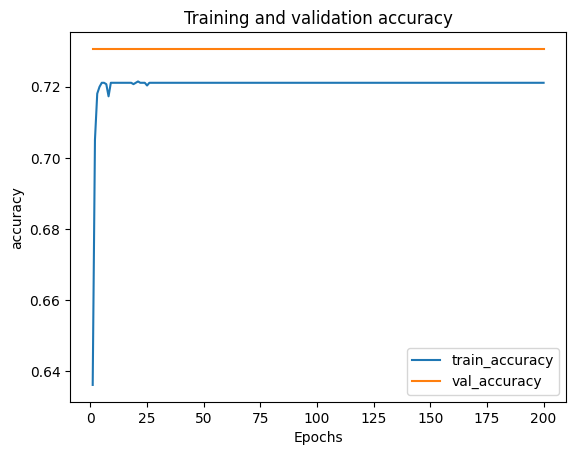

In [24]:
plot_metric(batched_history, 'accuracy')

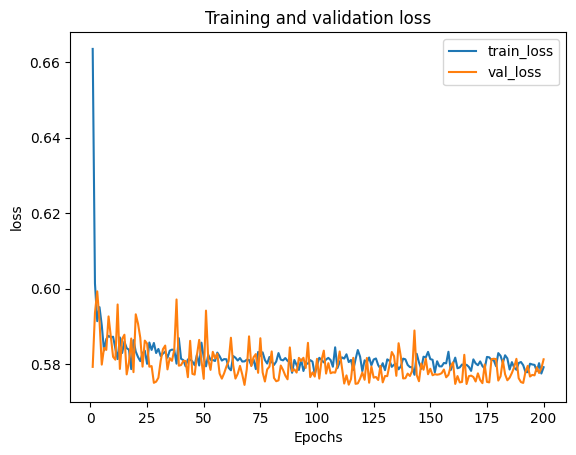

In [25]:
plot_metric(batched_history, 'loss')

In [22]:
batched_model.evaluate(X_test, y_test, verbose=2)

28/28 - 0s - loss: 0.5844 - accuracy: 0.7203 - 66ms/epoch - 2ms/step


[0.5844459533691406, 0.7203196287155151]